# Exploratory Data Analysis (EDA) for Fishy & Co.

<b>Name:</b> Ng Kok Woon (Nicky)<br>
<b>Email:</b> kokwoon.ng@gmail.com<br>
<b>Program ID:</b> eda.ipynb<br>
<b>Description:</b> Task 1 - EDA for AIAP Batch 14 Technical Assessment<br>
<b>Overview:</b> EDA for data collected by Fishy & Co. to be reviewed for task 2 of Machine-Learning Pipeline (MLP) building to predict rain to maximize catch and minimize unecessary cost for the company as the AI Engineer
<br>

# Content Sections:

1. [Libraries](#section1)
2. [Importing Data](#section2)
3. [Initital Data Exploration](#section3)
    - [Categorical Features](#section3-a)
    - [Numerical Features](#section3-b)
    - [Summary from Initital Data Exploration](#section3-c)
4. [Data Cleaning & Feature Engineering](#section4)
    - [Data Cleaning](#section4-a)
    - [Feature Engineering](#section4-b)
5. [Features Selection](#section5)
    - [Numerical](#section5-a)
    - [Categorical](#section5-b)
6. [Summary from Exploratory Data Analysis (EDA)](#section6)
7. [Appendix](#section7)

<a id='section1'></a>

## 1. Libraries<a id='section2'></a>

In [1]:
# 1. Import libraries
# ====================================================================================================

# Data Wrangling
import numpy as np 
import pandas as pd
from pandas.api.types import CategoricalDtype
from collections import Counter

# Date/Time
from datetime import datetime

# Databases
import sqlite3

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

# Statistics/Math
import scipy.stats as ss
import math

# Encoders
import category_encoders as ce
from sklearn import preprocessing

# Warnings & Display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('max_colwidth', 100)

<a id='section2'></a>

## 2. Importing Data

In [2]:
# 2. Read data as pd.DataFrame
# ===================================================================================================================

# Connection to SQLite database
try:
    conn = sqlite3.connect('./data/fishing.db')  
except Exception as err:
    print(f"Connection error:\n{err}")
      
# Extract data as pd.DataFrame
cursor = conn.cursor()
raw_df = pd.read_sql_query('SELECT * FROM fishing', conn)

# Close db connection
conn.close()

<a id='section3'></a>

## 3. Initital Data Exploration

In [3]:
# 3. Initital Data Exploration
# ===================================================================================================================

# Check data shape
raw_df.shape 

# 12,997 with 21 columns

(12997, 21)

In [4]:
# Check data summary
raw_df.info()

# There are some rows with missing data
# RainTomorrow of Date seems to be verifiable by RainToday of Date+1 (New Feature: Predict_True)
# Since there are missing RainToday, we should first engineer Predict_True variable and extract records of prediction is accurate and we can drop off the inaccurate ones before filtering NAs
# We can then impute missing data with value of '0' from the predictors before checking for variables to use for model
# There are categorical features that we should encode for training
# We can define new features (Cost to ship = 1) and (Haul = 2) to check which model would provide the best returns, based on ratio of 1:2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12997 entries, 0 to 12996
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           12997 non-null  object 
 1   Location       12997 non-null  object 
 2   Rainfall       12997 non-null  float64
 3   Evaporation    12917 non-null  float64
 4   Sunshine       12939 non-null  float64
 5   WindGustDir    12913 non-null  object 
 6   WindGustSpeed  12917 non-null  float64
 7   WindDir9am     12697 non-null  object 
 8   WindDir3pm     12945 non-null  object 
 9   WindSpeed9am   12992 non-null  float64
 10  WindSpeed3pm   12991 non-null  float64
 11  Humidity9am    12983 non-null  float64
 12  Humidity3pm    12970 non-null  float64
 13  Pressure9am    12995 non-null  object 
 14  Pressure3pm    12989 non-null  object 
 15  Cloud9am       12693 non-null  float64
 16  Cloud3pm       12615 non-null  float64
 17  RainToday      9799 non-null   object 
 18  RainTo

In [5]:
# Review 5 samples of dataset
raw_df.sample(5)

,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
9466,2010-04-11,Tuas,0.0,4.8,9.9,ENE,35.0,ENE,WNW,15.0,...,49.0,34.0,med,mEd,5.0,8.0,No,No,blue,31.6
1947,2017-04-01,Changi,0.2,7.4,9.8,WSW,22.0,WSW,S,9.0,...,54.0,40.0,MED,mEd,2.0,3.0,No,No,red,33.0
794,2015-12-18,Woodlands,8.6,4.0,4.3,NW,39.0,N,NNW,11.0,...,83.0,68.0,LoW,lOw,7.0,7.0,None,Yes,red,35.4
12417,2013-01-13,Changi,0.0,9.8,12.9,NE,28.0,NW,NE,4.0,...,60.0,57.0,Med,loW,1.0,1.0,No,No,white,35.4
5089,2012-03-07,Changi,7.4,2.8,-10.3,SE,30.0,S,ESE,7.0,...,66.0,53.0,med,med,1.0,5.0,Yes,No,red,32.7


In [6]:
# Check for duplications based on date-location pair
raw_df.duplicated(subset=['Date','Location'], keep = 'first').value_counts()

# There seems to be 1,182 duplicated date-location pairs, perform further checks to see if duplicate pairs have different values

False    11815
True      1182
dtype: int64

In [7]:
# Check if duplicated date-location pairs have different data
raw_df.duplicated(keep = 'first').value_counts()

# Seems like all the 1,182 duplicated date-location pairs are exact same duplications (Cleaning: Removal duplications)

False    11815
True      1182
dtype: int64

In [8]:
# Check for any incorrect tagging of RainToday based on definition that it has rained if there more than 1.0mm of rain in the day
raw_df[(raw_df['Rainfall'] > 1.0) & (raw_df['RainToday'] == "No")].count()

# All `RainToday` that are filled are accurate

Date             0
Location         0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainToday        0
RainTomorrow     0
ColourOfBoats    0
AverageTemp      0
dtype: int64

In [9]:
# Check if there are RainToday feature missing when it did rained baed on definition
raw_df[(raw_df['Rainfall'] > 1.0) & (raw_df['RainToday'].isna())].count()

# Seems like there are missing values in `RainToday` that we should process to ensure all values are filled accordingly

Date             738
Location         738
Rainfall         738
Evaporation      724
Sunshine         731
WindGustDir      729
WindGustSpeed    729
WindDir9am       707
WindDir3pm       734
WindSpeed9am     737
WindSpeed3pm     738
Humidity9am      738
Humidity3pm      738
Pressure9am      738
Pressure3pm      738
Cloud9am         730
Cloud3pm         722
RainToday          0
RainTomorrow     738
ColourOfBoats    738
AverageTemp      737
dtype: int64

<a id='section3-a'></a>

In [10]:
# 3a. Initital Data Exploration (Categorical Features)
# ===================================================================================================================

# Review summary categorical features
raw_df.describe(include = 'O')

# ColourOfBoats does not seem relevant to our problem (Cleaning: Removal)
# Pressure should only has 3 levels, but seems like there are 32 unique values for cleaning
# There are 18 wind directions for `WindGustDir` but only 16 for `WindDir3pm` and `WindDir9am`
# Seems like there are 4 unique locations but that should not affect our model (Cleaning: Removal)
# After our data cleaning and processing, we should be able to remove the `Date` variable (Cleaning: Removal)

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,ColourOfBoats
count,12997,12997,12913,12697,12945,12995,12989,9799,12997,12997
unique,3193,4,18,16,16,32,32,2,2,4
top,2011-01-24,Woodlands,E,N,SW,meD,mEd,No,No,blue
freq,8,3515,1333,1212,997,1030,988,7488,9998,3333


In [11]:
# Pressure Types at 9am
raw_df['Pressure9am'].unique()

array(['MED', 'MeD', 'Med', 'hIgh', 'meD', 'MEd', 'LOW', 'mED', 'HigH',
       'med', 'loW', 'hIgH', 'HiGh', 'LOw', 'hIGh', 'mEd', 'HIGH', 'lOw',
       'LoW', 'HIgh', 'HiGH', 'higH', 'hIGH', 'hiGH', 'low', 'HIGh',
       'Low', 'lOW', 'High', 'HIgH', 'high', 'hiGh', None], dtype=object)

In [12]:
# Pressure Types at 3pm
raw_df['Pressure3pm'].unique()

array(['Med', 'LOw', 'MEd', 'med', 'MeD', 'MED', 'lOW', 'meD', 'mEd',
       'HiGh', 'high', 'mED', 'LoW', 'HigH', 'HiGH', 'low', 'High', 'Low',
       'hIgH', 'loW', 'HIgh', 'HIGH', 'HIGh', 'higH', 'hIgh', 'LOW',
       'lOw', 'hiGH', 'hiGh', 'HIgH', 'hIGH', 'hIGh', None], dtype=object)

Based on the unique values of pressure, lower-casing the values should return only 3 values `[low, mid, high]`

In [13]:
# Test if assumption for pressure is accurate
test_df = raw_df.copy()

test_df['Pressure3pm'] = test_df['Pressure3pm'].str.lower()
test_df['Pressure9am'] = test_df['Pressure9am'].str.lower()
print(f"{test_df['Pressure3pm'].unique()}\n{test_df['Pressure9am'].unique()}")

['med' 'low' 'high' None]
['med' 'high' 'low' None]


In [14]:
# Wind drection for Strongest Gust direction 
raw_df['WindGustDir'].unique()

array(['E', 'WNW', 'ESE', 'NE', 'NNW', 'S', 'SSW', 'N', 'NW', 'ENE', 'W',
       'WSW', 'SSE', 'SW', 'SE', 'NNE', None, 'NS', 'EW'], dtype=object)

In [15]:
# Wind direction for 9pm
raw_df['WindDir9am'].unique()

array(['E', 'NNE', 'SE', 'NNW', 'N', 'SSE', 'S', 'WSW', 'ENE', 'WNW',
       'ESE', 'SSW', 'W', 'SW', 'NW', None, 'NE'], dtype=object)

In [16]:
# Wind direction for 3pm
raw_df['WindDir3pm'].unique()

array(['ESE', 'NW', 'E', 'NE', 'N', 'SSW', 'WNW', 'SSE', 'NNW', 'WSW',
       'NNE', 'ENE', 'SE', 'S', 'SW', 'W', None], dtype=object)

Wind direction values seems validated based on [Windy.app](https://windy.app/blog/what-is-wind-direction.html#:~:text=292.5%C2%B0%20%E2%80%94%20west%2Dnorthwest%20wind%20(WNW)), No changes required.

Text(0.5, 1.0, 'Countplot for `RainTomorrow` Labels')

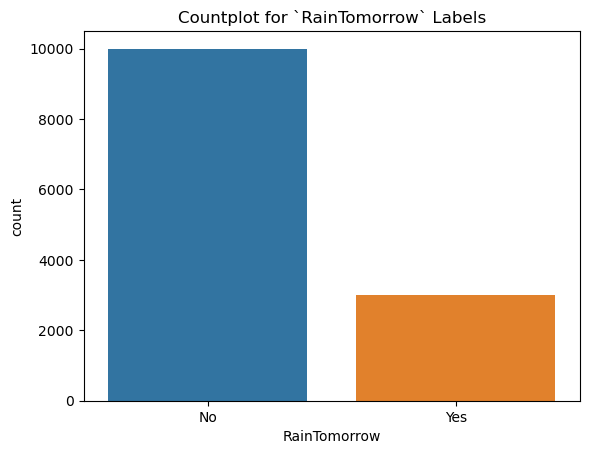

In [17]:
# Explore distribution of RainTomorrow labels
plt.figure()
ax = sns.countplot(x = "RainTomorrow", data = raw_df)
plt.title("Countplot for `RainTomorrow` Labels")

# Seems like there a much higher frequency of `No` for not raining prediction class and we may want to consider downsampling to avoid over-fitting

<a id='section3-b'></a>

In [18]:
# 3b. Initital Data Exploration (Numerical Features)
# ===================================================================================================================

raw_df.describe()

# We can review the numerical values with box plots & distribution plots to further check for outliers
# Looks like there are errors in `Sunshine` containing negative values
# `Cloud9am` and `Cloud3pm` is correct within the range of 0 - 8 based on Oktas scale
# `Rainfall`, `Evaporation` and `WindGustSpeed` seems to have drastic max values that we should review further after cleaning NAs

,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,AverageTemp
count,12997.000000,12917.000000,12939.000000,12917.000000,12992.000000,12991.000000,12983.000000,12970.000000,12693.000000,12615.000000,12988.000000
mean,3.040532,5.551955,6.496236,36.640164,12.456974,16.703102,65.476623,50.818813,4.108879,4.124138,31.522144
std,10.958255,2.898708,6.026236,12.628845,8.341814,7.882508,15.460822,16.865362,2.727825,2.646195,2.960591
min,0.000000,0.000000,-13.500000,9.000000,0.000000,0.000000,11.000000,5.000000,0.000000,0.000000,24.300000
25%,0.000000,3.400000,3.950000,28.000000,7.000000,11.000000,56.000000,40.000000,1.000000,1.000000,29.100000
50%,0.000000,5.400000,8.700000,35.000000,11.000000,15.000000,66.000000,51.000000,4.000000,4.000000,31.700000
75%,0.800000,7.400000,10.700000,43.000000,17.000000,20.000000,76.000000,61.000000,7.000000,7.000000,34.200000
max,367.600000,44.000000,13.900000,126.000000,65.000000,76.000000,100.000000,100.000000,8.000000,8.000000,38.500000


Reference link:<br>
[Oktas Scale](https://worldweather.wmo.int/oktas.htm)

array([[<AxesSubplot: title={'center': 'Rainfall'}>,
        <AxesSubplot: title={'center': 'Evaporation'}>,
        <AxesSubplot: title={'center': 'Sunshine'}>],
       [<AxesSubplot: title={'center': 'WindGustSpeed'}>,
        <AxesSubplot: title={'center': 'WindSpeed9am'}>,
        <AxesSubplot: title={'center': 'WindSpeed3pm'}>],
       [<AxesSubplot: title={'center': 'Humidity9am'}>,
        <AxesSubplot: title={'center': 'Humidity3pm'}>,
        <AxesSubplot: title={'center': 'Cloud9am'}>],
       [<AxesSubplot: title={'center': 'Cloud3pm'}>,
        <AxesSubplot: title={'center': 'AverageTemp'}>, <AxesSubplot: >]],
      dtype=object)

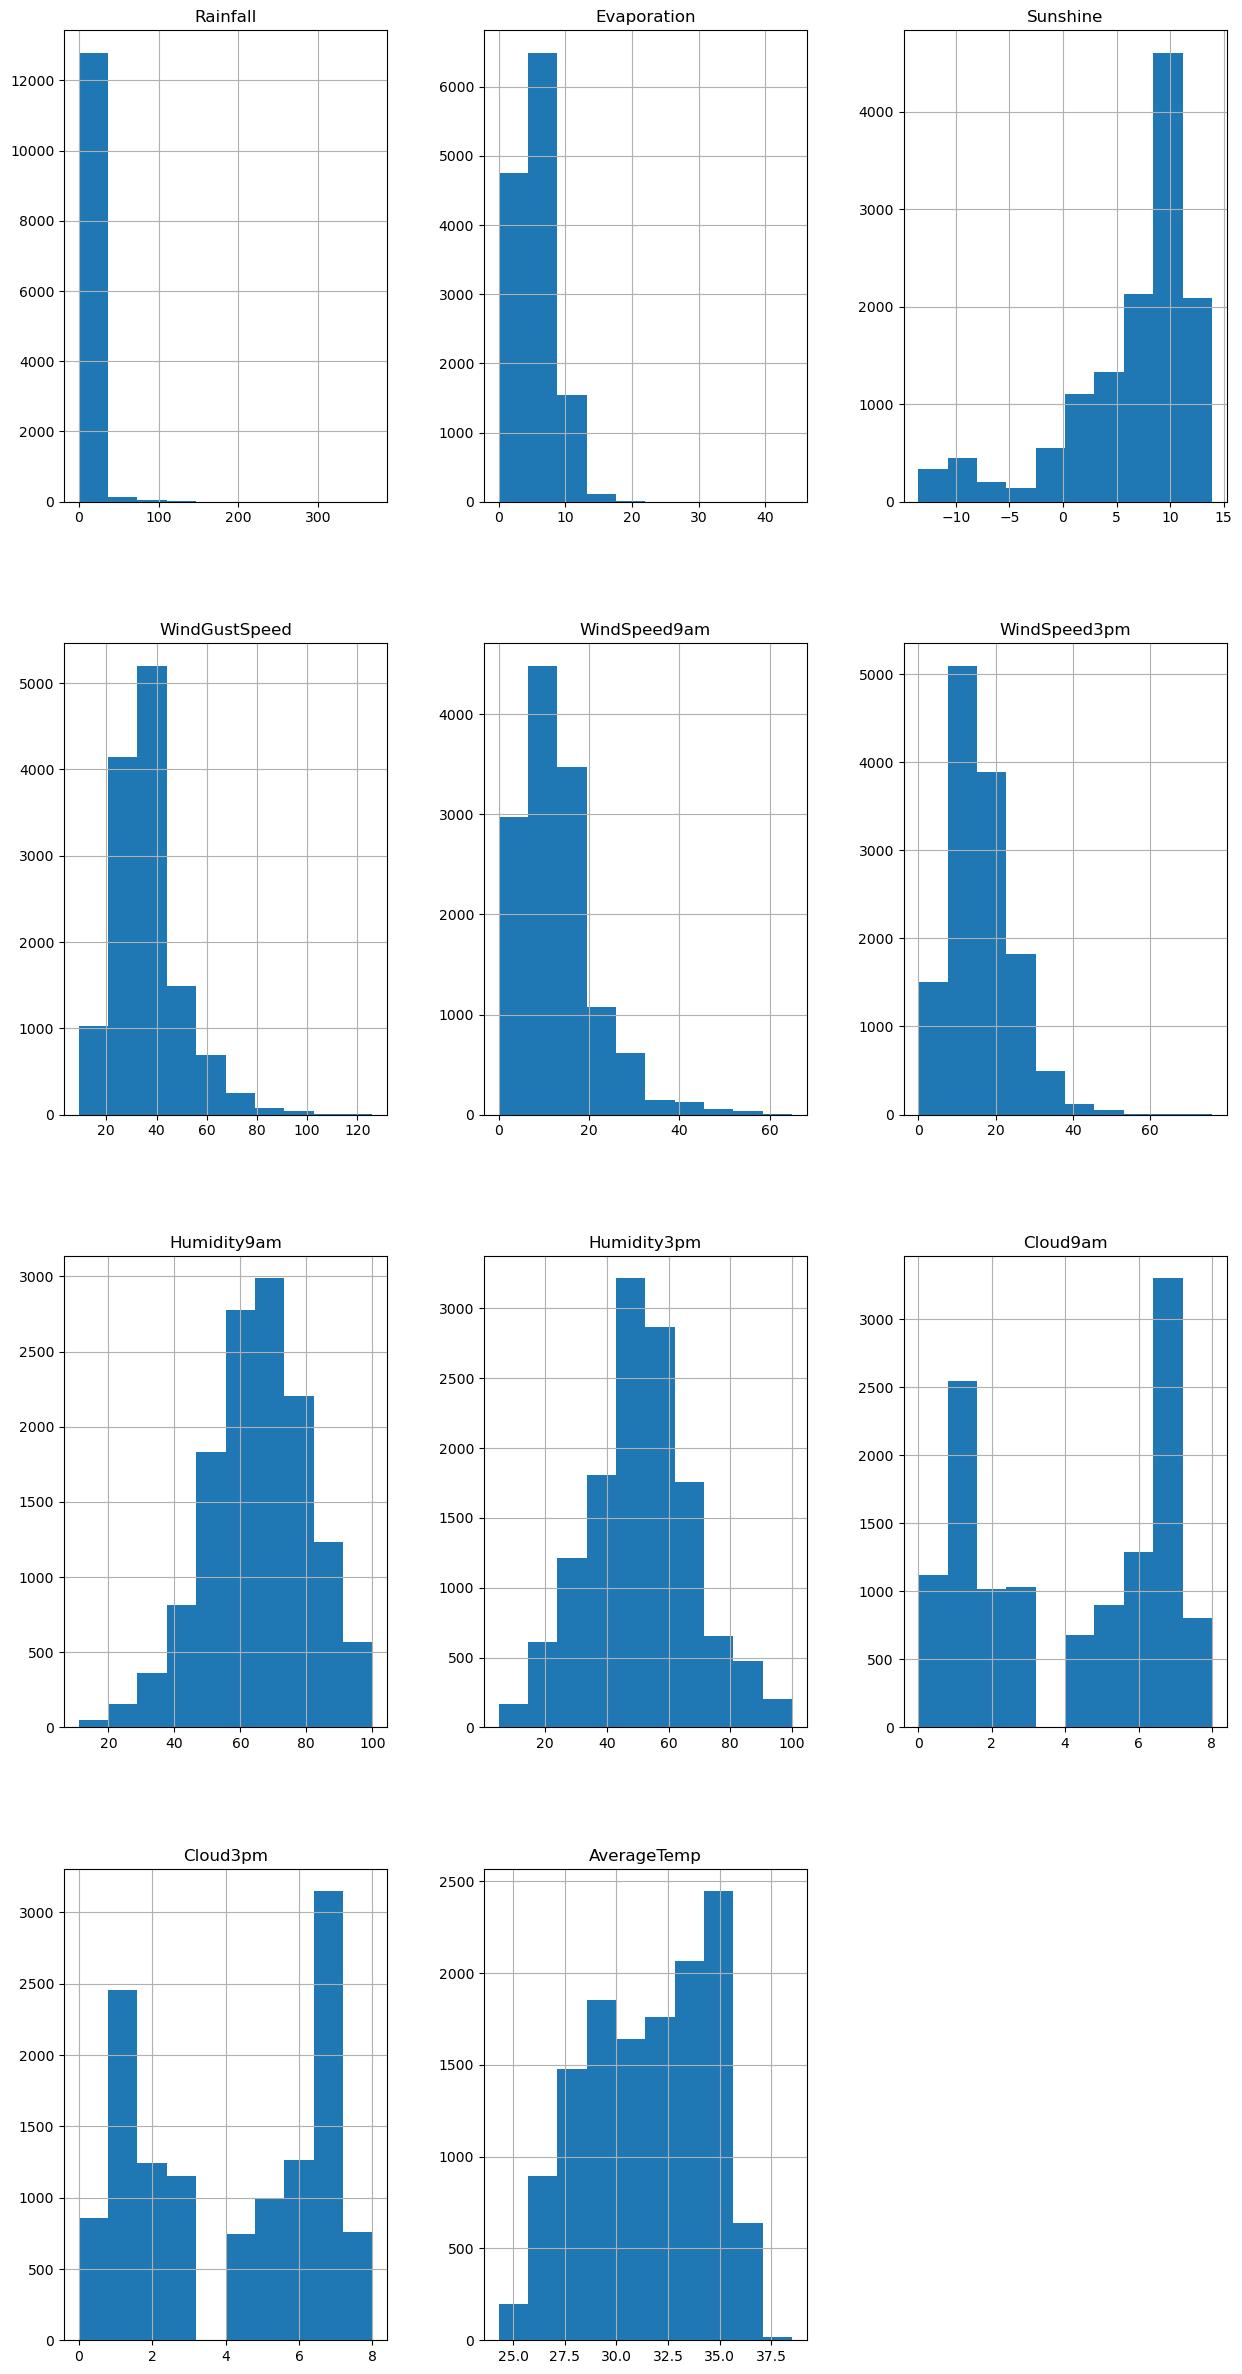

In [19]:
# Review distribution of all numerical features
raw_df.hist(figsize = (15, 30), layout = (4, 3))

# No. of hours of bright sunshine seems to have a number of negative values, we should further investigate
# Except for `Humidity9am` and `Humidity3pm`, all other features seem to have higher skewness and are not normally distributed (Engineering: Normalization), we can normalize all features

In [20]:
# Investigate further into #hours of sunshine
raw_df[raw_df['Sunshine'] < 0.0].count()

# There are over 1,000+ negative hours of sunshine, the assumption is that the no. of hours is incorrectly added to the data and it should be positive instead

Date             1230
Location         1230
Rainfall         1230
Evaporation      1228
Sunshine         1230
WindGustDir      1223
WindGustSpeed    1222
WindDir9am       1208
WindDir3pm       1226
WindSpeed9am     1229
WindSpeed3pm     1229
Humidity9am      1229
Humidity3pm      1225
Pressure9am      1229
Pressure3pm      1229
Cloud9am         1202
Cloud3pm         1190
RainToday         913
RainTomorrow     1230
ColourOfBoats    1230
AverageTemp      1228
dtype: int64

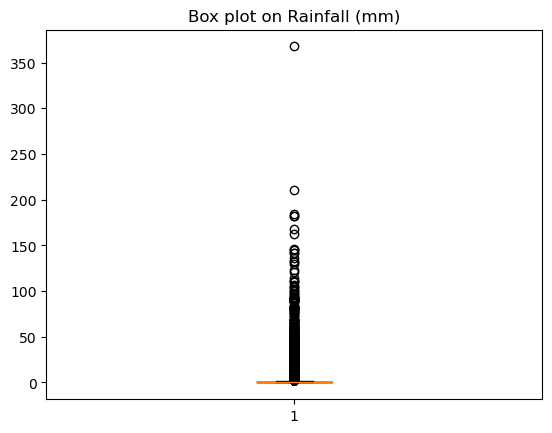

In [21]:
# Reviewing the Rainfall with box plot
fig, ax = plt.subplots()
ax.set_title('Box plot on Rainfall (mm)')
ax.boxplot(raw_df['Rainfall'])
plt.show()

# The max value of over 350 seems to be the main outlier as the data distribution is highly skewed towards 0 from our earlier findings

Reviewing online data from [weather.gov.sg](http://www.weather.gov.sg/climate-historical-extremes), it does seems like this outlier is acceptable with Singapore's highest daily rainfall hitting 512.4mm back in year 1929.

<a id='section3-c'></a>

## Summary from our initital data exploration
<b>(i) Target Label:</b><br>
    - Record's `RainTomorrow` for `Date` will be the target label for our project and it should be verified by `RainToday` label from `Date+1` to evaluate the correctness of records<br>
    - There is an uneven distribution skewed towards "No" for `RainTomorrow` and we should consider down-sampling the "No" class to reduce risk of over-fitting<br><br>
<b>(ii) Data Cleaning:</b><br>
    - There are `Date`-`Locations` pair duplicates that should be removed<br>
    - The `Pressure3pm` and `Pressure9am` categories has to be lowercased to standardise the 3 levels of pressure [low, med, high]<br>
    - There are missing fields in the `RainToday` field and they should be populated based on the `Rainfall` value<br>
    - `Sunshine` feature that represents # hours of bright sunshine contains negative values, assuming that they are incorrectly entered, all values are to be positive<br>
    - After our data cleaning, we should remove records with missing values<br><br>
<b>(iii) Data Pre-Processing/Feature Engineering:</b><br>
    - `Date` may contain trend(s) for rainfall and we can generate `month` variable as our predictor variable if deemed so after further investigation<br>
    - Numerical values except `Rainfall` does not have a large range but mostly are not normally distributed, we can normalize all the numerical features (MLP Pipeline) <br>
    - `Pressure9am` and `Pressure3pm` are ordinal data with the order of low -> high and thus we can perform label-encoding to preserve the ranking<br>
    - The other categorical features for wind direction are nominal data with a larger unique values and thus we should explore binary or baseN encoding<br><br>
<b>(iv) Unrequired Labels:</b><br>
    - Based on our project requirement, `ColourOfBoats` should not be a factor to consider for our classification model(s)<br>
    - `Date` and `Location` labels should also not be factors to considered<br>
    - `RainToday` will not be required after it has been used for verification for part (i) since it has <br>

<a id='section4'></a>

## 4. Data Cleaning & Feature Engineering

<a id='section4-a'></a>

In [22]:
# 4a. Remove date-locations pair values
# ===================================================================================================================

# Copy raw_df
cleaned_df = raw_df.copy()

# Remove duplications based on date-locations pair
cleaned_df.drop_duplicates(subset = ['Date', 'Location'], keep = 'first', inplace = True)
cleaned_df.shape # 11,815 rows with 21 columns

(11815, 21)

In [23]:
# 4b. Feature Engineering to verify target label
# ===================================================================================================================

# Clean values and re-generate values for `RainToday` based on definition (rained if `Rainfall` > 1) 
cleaned_df['RainToday'] = np.where(cleaned_df['Rainfall'] > 1.0, 'Yes', 'No')

# Convert `Date` column to datetime
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Create column `tmr_rain` to check if there are actual rainfall the next day
cleaned_df['tmr_rain'] = cleaned_df['Date'] + pd.Timedelta(days = 1)

# Extract `Date`-`RainToday` as dictionary
rain_dict = dict(zip(cleaned_df['Date'], cleaned_df['RainToday']))

# Replace `tmr_rain` column with the value from dictionary, if not found, return NaN
cleaned_df['tmr_rain'] = cleaned_df['tmr_rain'].map(rain_dict)
#cleaned_df[cleaned_df['RainTomorrow'] != cleaned_df['tmr_rain']][['Date', 'Location', 'RainToday', 'RainTomorrow', 'tmr_rain']].sort_values(by = 'Date')

# Create column `predict_accurate` to track records where prediction of `RainTomorrow` had been accurate else inaccurate
cleaned_df['predict_accurate'] = np.where(cleaned_df['RainTomorrow'] == cleaned_df['tmr_rain'], 'Yes', 'No')
#cleaned_df[cleaned_df['tmr_rain'].isna()]

In [24]:
# Check number of records left that are valid that we can use for training
filtered_df = cleaned_df[cleaned_df['predict_accurate'] == 'Yes']
filtered_df.info() # 8,559

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8559 entries, 0 to 12996
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              8559 non-null   datetime64[ns]
 1   Location          8559 non-null   object        
 2   Rainfall          8559 non-null   float64       
 3   Evaporation       8514 non-null   float64       
 4   Sunshine          8518 non-null   float64       
 5   WindGustDir       8506 non-null   object        
 6   WindGustSpeed     8510 non-null   float64       
 7   WindDir9am        8351 non-null   object        
 8   WindDir3pm        8524 non-null   object        
 9   WindSpeed9am      8558 non-null   float64       
 10  WindSpeed3pm      8557 non-null   float64       
 11  Humidity9am       8551 non-null   float64       
 12  Humidity3pm       8542 non-null   float64       
 13  Pressure9am       8558 non-null   object        
 14  Pressure3pm       8555 

In [25]:
# 4c. Data Cleaning
# ===================================================================================================================

# Standardize pressure values
filtered_df['Pressure3pm'] = filtered_df['Pressure3pm'].str.lower()
filtered_df['Pressure9am'] = filtered_df['Pressure9am'].str.lower()
print(f"{filtered_df['Pressure3pm'].unique()}\n{filtered_df['Pressure9am'].unique()}")

['med' 'high' 'low' None]
['med' 'high' 'low' None]


In [26]:
# Convert all `Sunshine` values to positive value
filtered_df['Sunshine'] = filtered_df['Sunshine'].apply(abs)
filtered_df['Sunshine'].describe()

# All values in `Sunshine` are now positive value in (0,13.9]

count    8518.000000
mean        8.406234
std         3.461417
min         0.000000
25%         6.400000
50%         9.500000
75%        10.900000
max        13.900000
Name: Sunshine, dtype: float64

In [27]:
# Drop all records with missing values
na_removed_df = filtered_df.dropna()
na_removed_df.info() # 7,917

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7917 entries, 0 to 12996
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7917 non-null   datetime64[ns]
 1   Location          7917 non-null   object        
 2   Rainfall          7917 non-null   float64       
 3   Evaporation       7917 non-null   float64       
 4   Sunshine          7917 non-null   float64       
 5   WindGustDir       7917 non-null   object        
 6   WindGustSpeed     7917 non-null   float64       
 7   WindDir9am        7917 non-null   object        
 8   WindDir3pm        7917 non-null   object        
 9   WindSpeed9am      7917 non-null   float64       
 10  WindSpeed3pm      7917 non-null   float64       
 11  Humidity9am       7917 non-null   float64       
 12  Humidity3pm       7917 non-null   float64       
 13  Pressure9am       7917 non-null   object        
 14  Pressure3pm       7917 

<a id='section4-b'></a>

In [28]:
# 4d. Feature Engineering
# ===================================================================================================================

# Create copy of processed dataframe
prep_df = na_removed_df.copy()

# Extract month from `Date` column
prep_df['month'] = pd.DatetimeIndex(prep_df['Date']).month
prep_df['month'].unique()

array([ 3, 10,  2,  5,  7, 11,  4,  1,  9,  8, 12,  6], dtype=int64)

Text(0.5, 1.0, 'Frequency of rain month over month')

<Figure size 640x480 with 0 Axes>

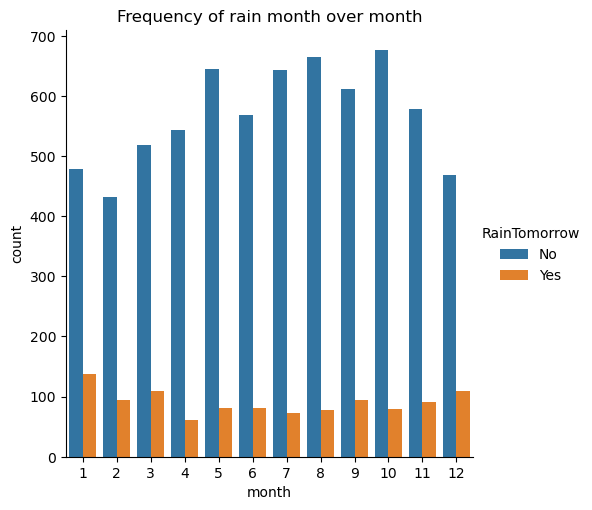

In [29]:
# Review month against accurate prediction
plt.figure()
sns.catplot(data = prep_df, x = 'month', hue = 'RainTomorrow', kind = 'count')
plt.title("Frequency of rain month over month")

# There does seems to be a likely indication that Nov - Dec is the wetter season from the plot, we can measure the correlation coefficient to determine if it's a suitable predictor

In [30]:
# Normalization of numerical data is not required at this stage, it will be performed in the MLP

In [31]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7917 entries, 0 to 12996
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7917 non-null   datetime64[ns]
 1   Location          7917 non-null   object        
 2   Rainfall          7917 non-null   float64       
 3   Evaporation       7917 non-null   float64       
 4   Sunshine          7917 non-null   float64       
 5   WindGustDir       7917 non-null   object        
 6   WindGustSpeed     7917 non-null   float64       
 7   WindDir9am        7917 non-null   object        
 8   WindDir3pm        7917 non-null   object        
 9   WindSpeed9am      7917 non-null   float64       
 10  WindSpeed3pm      7917 non-null   float64       
 11  Humidity9am       7917 non-null   float64       
 12  Humidity3pm       7917 non-null   float64       
 13  Pressure9am       7917 non-null   object        
 14  Pressure3pm       7917 

Text(0.5, 1.0, 'Distribution of accurate prediction of rain')

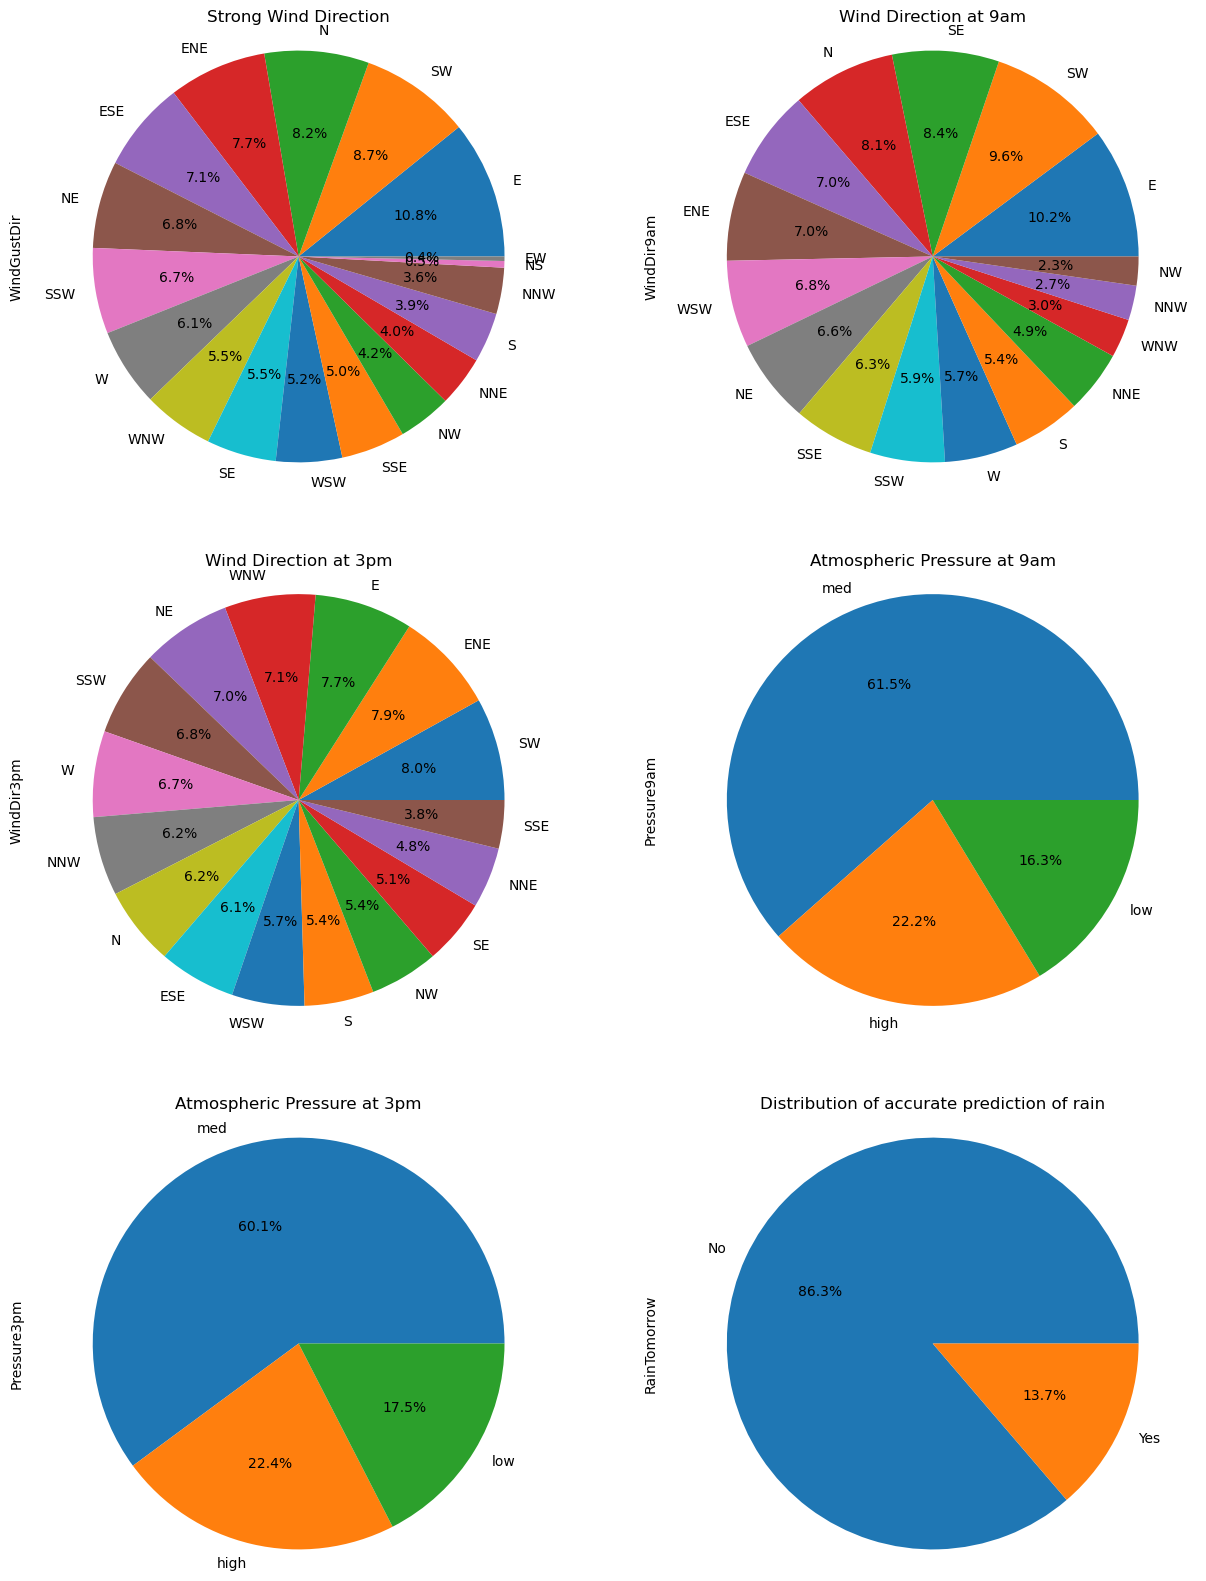

In [32]:
# Visualize the distribution of categorical variables before encoding
fig = plt.figure(figsize = (15, 20))

# Wind Gust Direction
ax = fig.add_subplot(321)
prep_df['WindGustDir'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.axis('equal')
plt.title('Strong Wind Direction')

# Wind Direction at 9am
ax = fig.add_subplot(322)
prep_df['WindDir9am'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.axis('equal')
plt.title('Wind Direction at 9am')

# Wind Direction at 3pm
ax = fig.add_subplot(323)
prep_df['WindDir3pm'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.axis('equal')
plt.title('Wind Direction at 3pm')

# Pressure at 9am
ax = fig.add_subplot(324)
prep_df['Pressure9am'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.axis('equal')
plt.title('Atmospheric Pressure at 9am')

# Pressure at 93pm
ax = fig.add_subplot(325)
prep_df['Pressure3pm'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.axis('equal')
plt.title('Atmospheric Pressure at 3pm')

# Rain Tomorrow
ax = fig.add_subplot(326)
prep_df['RainTomorrow'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.axis('equal')
plt.title('Distribution of accurate prediction of rain')

Generally, we can see that the wind directional features are quite well distributed.<br>
The atmospheric pressure features are skewed towards 'med' but that should not affect us much<br>
Accurate rain prediction are largely skewed towards not-raining, we should explore downsampling of 'No' labels for our model building.

<a id='section5'></a>

## 5. Features Selection

<a id='section5-a'></a>

<AxesSubplot: >

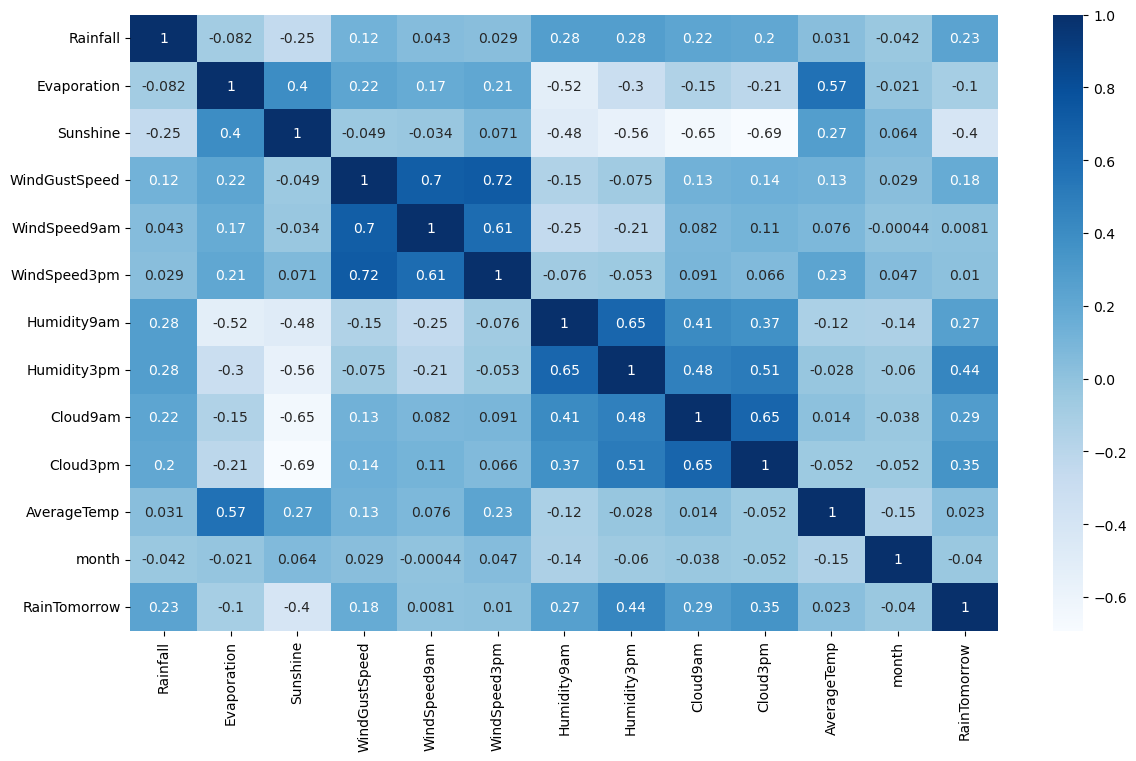

In [33]:
# 5a. Feature Selection for numerical features - target
# ===================================================================================================================

# Copy existing prepared df
encode_df = prep_df.copy()

# Extract numerical features & target
num_df = encode_df[['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                    'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'AverageTemp', 'month',
                    'RainTomorrow']]

num_df['RainTomorrow'] = np.where(num_df['RainTomorrow'] == 'Yes', 1, 0)

# Review measure of association with Pearson's Corelation
plt.figure(figsize=(14,8))
sns.heatmap(num_df.corr(numeric_only = True), annot = True, cmap = 'Blues')

<b>Numerical Feature Selection Summary:</b><br>
    - Based on our correlation matrix, we can see that for the class `RainTomorrow`, there are no features with exceptionally strong linear or strong negative linear relationship.<br>
    - However, if we were to use `0.3` as our threshold to select features with moderate linear relationship with our target, we will be able to identify the features: `Sunshine`, `Humidity3pm`, `Cloud3pm` and `month`.

<a id='section5-b'></a>

In [34]:
# 5b. Feature Selection for categorical features - target
# ===================================================================================================================

# Define support functions to help us with calculation of the uncertainty coefficient (Theil's U)
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

# Extract categorical features & target
cat_df = encode_df[['WindGustDir', 'Pressure9am', 'Pressure3pm', 'WindDir9am', 'WindDir3pm', 'RainTomorrow']]

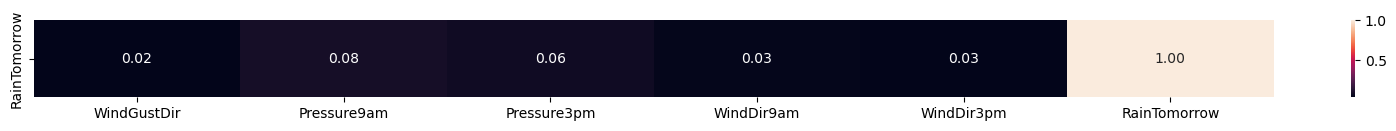

In [35]:
# Extract the categorical features from the data to test for assocation using uncertainty coefficient (Theil's U) through the measure of nominal association
theilu = pd.DataFrame(index = ['RainTomorrow'], columns = cat_df.columns)
columns = cat_df.columns

# Apply function and review correlation of heat map
for j in range(0, len(columns)):
    u = theil_u(cat_df['RainTomorrow'].tolist(), cat_df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value = np.nan, inplace = True)
plt.figure(figsize = (20,1))
sns.heatmap(theilu, annot = True, fmt = '.2f')
plt.show()

<b>Categorical Feature Selection Summary:</b><br>
    - Based on our correlation matrix, we can see that `Pressure9am` and `Pressure3pm` has strong correlation relationship with the target label `RainTomorrow`.<br>
    - Using `0.3` as our threshold to select features with moderate relationship with our target, we will be able see that the features `WindDir9am` and `WindDir3pm` does has some moderate correlation relationship with the target label as well.

<a id='section6'></a>

## 6. Summary from Exploratory Data Analysis (EDA)
### Follow-up for Task 2 - MLP
<b>(i) Target Label:</b><br>
    - Record's `RainTomorrow` for `Date` will be the target label for our project and it should be verified by `RainToday` label from `Date+1` to evaluate the correctness of records<br>
    - There is an uneven distribution skewed towards "No" for `RainTomorrow` and we should consider down-sampling the "No" class to reduce risk of over-fitting<br><br>
<b>(ii) Data Cleaning:</b><br>
    - There are `Date`-`Locations` pair duplicates that should be removed<br>
    - The `Pressure3pm` and `Pressure9am` categories has to be lowercased to standardise the 3 levels of pressure [low, med, high]<br>
    - There are missing fields in the `RainToday` field and they should be populated based on the `Rainfall` value<br>
    - `Sunshine` feature that represents # hours of bright sunshine contains negative values, assuming that they are incorrectly entered, all values are to be positive<br>
    - After our data cleaning, we should remove records with missing values<br><br>
<b>(iii) Data Pre-Processing/Feature Engineering:</b><br>
    - Based on our engineered feature `month`, we can see that `month` does have some linear correlation with the target class.<br><br>
<b>(iv) Feature Selection/Encoding:</b><br>
    - Applying Pearson's Coefficient for our numerical feature selection, there are no features with strong linear correlation (> 0.5 or < -0.5) with our target label, using a threshold of `0.3`, we can select the `Sunshine`, `Humidity3pm`, `Cloud3pm` and `month`<br>
    - Applying Uncertainty Coefficient (Thiel-U) for our categorical feature selection, `Pressure9am` and `Pressure3pm` has strong correlation with our target label, with `WindDir9am` and `WindDir3pm` having moderate strength, we will need to apply encoding to use them for our models.<br>
    - Numerical values except `Rainfall` does not have a large range but mostly are not normally distributed, we can normalize all the numerical features (MLP Pipeline) <br>
    - `Pressure9am` and `Pressure3pm` are ordinal data with the order of low -> high and thus we can perform label-encoding to preserve the ranking<br>
    - The other categorical features for wind direction are nominal data with a larger unique values and thus we should explore binary or baseN encoding<br><br>
<b>(v) Unrequired Labels:</b><br>
    - Based on our project requirement, `ColourOfBoats` should not be a factor to consider for our classification model(s)<br>
    - `Date` and `Location` labels should also not be factors to considered<br>
    - `RainToday` will not be required after it has been used for verification for part (i)<br><br>
<b>(vi) Summary for Machine-Learning Pipeline (MLP):</b><br>
    - From the EDA, we can see that the features that we will keep for our project includes `Sunshine`, `Humidity3pm`, `Cloud3pm`, `month`, `Pressure9am (Encoding)`, `Pressure3pm (Encoding)`, `WindDir9am (Encoding)`, `WindDir3pm (Encoding)` and `RainTomorrow (Target Class)` to tackle the challenge as a binary classification problem

<a id='section7'></a>

## 7. Appendix

```
# 7a. Feature Engineering - Encoding for Pressure categorical features
# ===================================================================================================================

# Copy existing prepared df
encode_df = prep_df.copy()

# Converting `Pressure9am` and `Pressure3pm` to categorical type
status_type = CategoricalDtype(categories = ['low', 'med', 'high'], ordered = True)
encode_df['Pressure9am'] = encode_df['Pressure9am'].astype(status_type)
encode_df['Pressure3pm'] = encode_df['Pressure3pm'].astype(status_type)

encode_df['Pressure9am'].unique()
#encode_df.dtypes
```

Unfortunately, [sklearn.preprocessing.LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) encodes the string based on alphabetical order instead of the order specified by us. 

```
# Perform label encoding
le = preprocessing.LabelEncoder()
encode_df['Pressure9am_encode'] = le.fit_transform(encode_df['Pressure9am'])
encode_df['Pressure3pm_encode'] = le.fit_transform(encode_df['Pressure3pm'])

# Returns
['med', 'high', 'low']
Categories (3, object): ['low' < 'med' < 'high']
[2 0 1]
```

Thus, we will have to perform manual label encoding, we can review what are the other better methods in the future.

```
# Perform manual encoding for Pressure
encode_df['Pressure9am_encode'] = np.where(encode_df['Pressure9am'] == 'low', 0, np.where(encode_df['Pressure9am'] == 'med', 1, 2))
encode_df['Pressure3pm_encode'] = np.where(encode_df['Pressure3pm'] == 'low', 0, np.where(encode_df['Pressure3pm'] == 'med', 1, 2))

print(encode_df['Pressure9am_encode'].unique())
print(encode_df['Pressure9am'].unique())
```

```
# Drop off `Pressure9am` and `Pressure3pm` Features
encode_df.drop(columns = ['Pressure3pm', 'Pressure9am'], inplace = True)
encode_df.columns
```